In [ ]:
!pip install sentence_transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.5/171.5 kB 3.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
import re
import spacy
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from gensim.models import KeyedVectors
import gensim.downloader as api
import string
from nltk.stem import WordNetLemmatizer
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

## 1. Logistic Regression
from sklearn.linear_model import LogisticRegression
## 2. Support Vector Machine
from sklearn.svm import SVC
## 3. Feed forward neural network or multi-layered perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
# compute "goodness" of classification through accuracy
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# load dataset
df = pd.read_csv("data (1).csv")
df.head(10)

,Unnamed: 0,Date,category,title,content,Volume,label,sentiment,cleaned title
0,0,2020-01-27,opinion,Apple Set To Beat Q1 Earnings Estimates Tech ...,Technology giant Apple NASDAQ AAPL is set ...,161940000,0,NaN,apple set beat q1 earnings estimate tech etf buy
1,1,2020-01-27,opinion,Tech Daily Intel Results Netflix Surge Appl...,The top stories in this digest are Intel s N...,161940000,0,NaN,tech daily intel result netflix surge apple va...
2,2,2020-01-27,opinion,7 Monster Stock Market Predictions For The Wee...,S P 500 SPY \nThis week will be packed with e...,161940000,0,NaN,7 monster stock market prediction week january 27
3,3,2020-01-27,opinion,Apple Earnings Preview 5G Launch Expanding S...,Reports Q1 2020 results on Tuesday Jan 28 ...,161940000,0,NaN,apple earnings preview 5g launch expanding ser...
4,4,2020-01-27,opinion,Buy Surging Apple Microsoft Stock Before Qua...,On today s episode of Full Court Finance here ...,161940000,0,NaN,buy surging apple microsoft stock quarterly ea...
5,5,2020-01-27,opinion,Top Stock Analyst Reports For Merck Broadcom ...,Monday January 27 2020The Zacks Research Dai...,161940000,0,NaN,top stock analyst report merck broadcom sanofi
6,6,2020-01-27,news,Stocks Europe Seen Opening Lower as Virus Co...,By Peter Nurse \nInvesting com European stoc...,161940000,0,NaN,stock europe seen opening lower virus concern ...
7,7,2020-01-27,news,Intelligent Systems wins bullish rating from B...,BTIG analyst Mark Palmer initiates coverage of...,161940000,0,NaN,intelligent system win bullish rating btig app...
8,8,2020-01-24,opinion,What To Do If A Stock On Your Buy List Has A...,I got a great question recently from Barbara P...,146537600,0,NaN,stock buy list already run 100
9,9,2020-01-24,opinion,Previewing Tech Sector Earnings,We get into the heart of the Q4 earnings seaso...,146537600,0,NaN,previewing tech sector earnings


In [ ]:
positive_file = "positive-words.txt"
positive_words = []

with open(positive_file, "r") as file:
  positive_words = file.readlines()

positive_words = [word.strip() for word in positive_words]

print(positive_words[:20])

['abound', 'abounds', 'abundance', 'abundant', 'accessable', 'accessible', 'acclaim', 'acclaimed', 'acclamation', 'accolade', 'accolades', 'accommodative', 'accomodative', 'accomplish', 'accomplished', 'accomplishment', 'accomplishments', 'accurate', 'accurately', 'achievable']


In [ ]:
negative_file = "negative-words.txt"
negative_words = []

with open(negative_file, "r") as file:
  negative_words = file.readlines()

negative_words = [word.strip() for word in negative_words]

print(negative_words[:10])

['2-faced', '2-faces', 'abnormal', 'abolish', 'abominable', 'abominably', 'abominate', 'abomination', 'abort', 'aborted']


In [ ]:
#load api
import gensim.downloader as api

word2vec_model = api.load("word2vec-google-news-300")


[==================================================] 100.0% 1662.8/1662.8MB downloaded


In [ ]:
from nltk.tokenize import word_tokenize
nltk.download('punkt')
#load pre-trained Word2Vec model

# Function to calculate the average vector for a list of words
def average_vector(words):
    vectors = []
    for word in words:
        try:
            vectors.append(word2vec_model[word])
        except KeyError:
            pass
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(word2vec_model.vector_size)

# Function to calculate sentiment score for a headline
def calculate_sentiment_score(headline):
    tokens = word_tokenize(headline.lower())
    headline_vector = average_vector(tokens)
    positive_score = np.dot(headline_vector, positive_vector)
    negative_score = np.dot(headline_vector, negative_vector)
    if positive_score >= negative_score:
        return 'positive'
    else:
        return 'negative'

# Create positive and negative vectors
positive_vector = average_vector(positive_words)
negative_vector = average_vector(negative_words)

# Apply sentiment analysis to each headline
df['sentiment'] = df['cleaned title'].apply(calculate_sentiment_score)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df.head(20)

,Unnamed: 0,Date,category,title,content,Volume,label,sentiment,cleaned title
0,0,2020-01-27,opinion,Apple Set To Beat Q1 Earnings Estimates Tech ...,Technology giant Apple NASDAQ AAPL is set ...,161940000,0,negative,apple set beat q1 earnings estimate tech etf buy
1,1,2020-01-27,opinion,Tech Daily Intel Results Netflix Surge Appl...,The top stories in this digest are Intel s N...,161940000,0,negative,tech daily intel result netflix surge apple va...
2,2,2020-01-27,opinion,7 Monster Stock Market Predictions For The Wee...,S P 500 SPY \nThis week will be packed with e...,161940000,0,negative,7 monster stock market prediction week january 27
3,3,2020-01-27,opinion,Apple Earnings Preview 5G Launch Expanding S...,Reports Q1 2020 results on Tuesday Jan 28 ...,161940000,0,positive,apple earnings preview 5g launch expanding ser...
4,4,2020-01-27,opinion,Buy Surging Apple Microsoft Stock Before Qua...,On today s episode of Full Court Finance here ...,161940000,0,negative,buy surging apple microsoft stock quarterly ea...
5,5,2020-01-27,opinion,Top Stock Analyst Reports For Merck Broadcom ...,Monday January 27 2020The Zacks Research Dai...,161940000,0,negative,top stock analyst report merck broadcom sanofi
6,6,2020-01-27,news,Stocks Europe Seen Opening Lower as Virus Co...,By Peter Nurse \nInvesting com European stoc...,161940000,0,negative,stock europe seen opening lower virus concern ...
7,7,2020-01-27,news,Intelligent Systems wins bullish rating from B...,BTIG analyst Mark Palmer initiates coverage of...,161940000,0,positive,intelligent system win bullish rating btig app...
8,8,2020-01-24,opinion,What To Do If A Stock On Your Buy List Has A...,I got a great question recently from Barbara P...,146537600,0,negative,stock buy list already run 100
9,9,2020-01-24,opinion,Previewing Tech Sector Earnings,We get into the heart of the Q4 earnings seaso...,146537600,0,positive,previewing tech sector earnings


In [ ]:
df["sentiment"].value_counts()

sentiment
negative    9862
positive    6113
Name: count, dtype: int64

In [ ]:
#split data intro training and testing data

training_data = df.sample(frac=0.8, random_state=25)
testing_data = df.drop(training_data.index)

#function to extract sentence vectors
def extract_sentence_vector(sentence, word2vec_model):
  words = sentence.split()
  word_vectors = [word2vec_model[word] for word in words if word in word2vec_model]
  if not word_vectors:
    return np.zeroes(word2vec_model.vector_size)
  sentence_vector = np.mean(word_vectors, axis = 0)
  return sentence_vector


In [ ]:
#apply function to data
training_data['sentence_vector'] = training_data['cleaned title'].apply(lambda x: extract_sentence_vector(x, word2vec_model))
testing_data['sentence_vector'] = testing_data['cleaned title'].apply(lambda x: extract_sentence_vector(x, word2vec_model))


In [ ]:
# prepare data for model training
X_train = np.array(list(training_data['sentence_vector']))
y_train = training_data['label'].values

X_test = np.array(list(testing_data['sentence_vector']))
y_test = testing_data['label'].values

In [ ]:
# logistic regresson

classifier_lr = LogisticRegression(max_iter=1000)

classifier_lr.fit(X_train, y_train)

y_pred = classifier_lr.predict(X_test)

#Calculate accuracy of model
accuracy_lr = accuracy_score(y_test, y_pred)
print(f"Accuracy of Logistic Regression = {accuracy_lr*100}%")

Accuracy of Logistic Regression = 54.960876369327075%


In [ ]:
# SVC

classifier_svc = SVC(max_iter=1000)

classifier_svc.fit(X_train, y_train)

y_pred = classifier_svc.predict(X_test)

accuracy_svc = accuracy_score(y_test,y_pred)
print(f"Accuracy of Support Vector Classification = {accuracy_svc*100}%")

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy of Support Vector Classification = 50.73552425665102%


In [ ]:
# Feed Forward Network

classifier_ffn = MLPClassifier(max_iter=1000)

classifier_ffn.fit(X_train,y_train)

y_pred = classifier_ffn.predict(X_test)

# Calculate the accuracy of model
accuracy_ffn =ffn = accuracy_score(y_test, y_pred)
print(f"Accuracy of Feed Forward Network = {accuracy_ffn*100}%")

Accuracy of Feed Forward Network = 52.98904538341158%


## Sentence Embeddings ##

In [ ]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

# Load a pre-trained BERT model
model = SentenceTransformer('bert-base-uncased')

training_data['sentence_vector'] = training_data['cleaned title'].apply(lambda x: model.encode(x))
testing_data['sentence_vector'] = testing_data['cleaned title'].apply(lambda x: model.encode(x))


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
columns = df.columns
print(columns)

Index(['Unnamed: 0', 'Date', 'category', 'title', 'content', 'Volume', 'label',
       'sentiment', 'cleaned title'],
      dtype='object')


In [ ]:
encoded_df = pd.DataFrame()
encoded_df['category'] = df['category'].apply(lambda x: 1 if x == 'news' else 0)
encoded_df['volume'] = df['Volume']
df['Date'] = pd.to_datetime(df['Date'])
encoded_df['year'] = df['Date'].dt.year
encoded_df['month'] = df['Date'].dt.month
encoded_df['day'] = df['Date'].dt.day
encoded_df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == 'positive' else 0)
encoded_df['label'] = df['label']

In [ ]:
encoded_df.head()

,category,volume,year,month,day,sentiment,label
0,0,161940000,2020,1,27,0,0
1,0,161940000,2020,1,27,0,0
2,0,161940000,2020,1,27,0,0
3,0,161940000,2020,1,27,1,0
4,0,161940000,2020,1,27,0,0


In [ ]:
#train test split
from sklearn.model_selection import train_test_split

X = encoded_df[['category', 'volume','year', 'month', 'day', 'sentiment']]  # Features
y = encoded_df['label']                                # Target variable

# Split the data into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=14)

In [ ]:
# logistic regression

# Initialize and train the logistic regression model
classifier_LR = LogisticRegression(max_iter=1000)
classifier_LR.fit(X_train, y_train)

# Predict on the test set
y_pred_LR = classifier_LR.predict(X_test)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_LR)
print(f"Accuracy of Logistic Regression: {accuracy_lr*100}%")

Accuracy of Logistic Regression: 55.305164319248824%


In [ ]:
# SVC
# Initialize and train the logistic regression model
classifier_SVC = SVC(max_iter=1000)
classifier_SVC.fit(X_train, y_train)

# Predict on the test set
y_pred_SVC = classifier_SVC.predict(X_test)

# Evaluate the model
accuracy_svc = accuracy_score(y_test, y_pred_SVC)
print(f"Accuracy of Support Vector Classification: {accuracy_svc*100}%")

/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Accuracy of Support Vector Classification: 55.712050078247266%


In [ ]:
#FFN

# Initialize and train the logistic regression model
classifier_FFN = MLPClassifier(max_iter=1000)
classifier_FFN.fit(X_train, y_train)

# Predict on the test set
y_pred_FFN = classifier_FFN.predict(X_test)

# Evaluate the model
accuracy_ffn = accuracy_score(y_test, y_pred_FFN)
print(f"Accuracy of Feed Forward Network: {accuracy_ffn*100}%")

Accuracy of Feed Forward Network: 44.69483568075117%


In [ ]:
# random forest

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Create a Random Forest Classifier
classifier_rf = RandomForestClassifier()

# Fit the model on the training data
classifier_rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier_rf.predict(X_test)

# Calculate the accuracy of the model
accuracy_rf = accuracy_score(y_test, y_pred)
print(f"Accuracy of Random Forest Classifier = {accuracy_rf*100}%")
# Generate the classification report
report_rf = classification_report(y_test, y_pred)
print("Classification Report for Random Forest Classifier:")
print(report_rf)

Accuracy of Random Forest Classifier = 97.7151799687011%
Classification Report for Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.98      0.97      0.97      1428
           1       0.97      0.98      0.98      1767

    accuracy                           0.98      3195
   macro avg       0.98      0.98      0.98      3195
weighted avg       0.98      0.98      0.98      3195



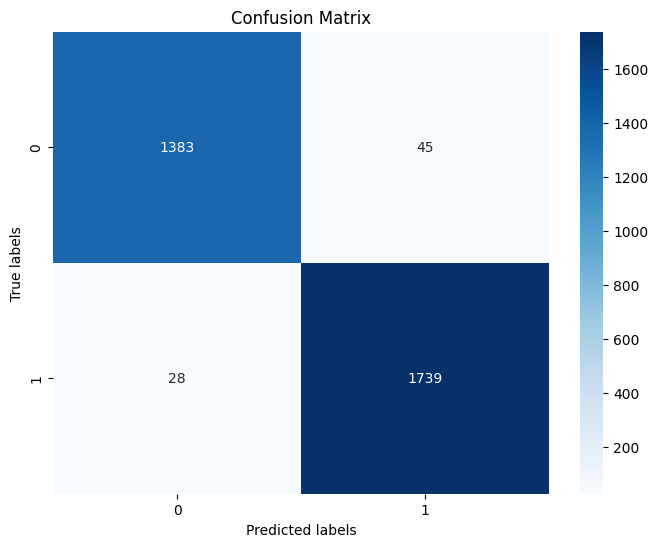

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Assuming y_true and y_pred are your true and predicted labels
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.9747757847533632
Recall: 0.9841539332201471
F1 Score: 0.9794424105885666


In [ ]:
# gradient boosting

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score

# Create a Gradient Boosting Classifier
classifier_gbm = GradientBoostingClassifier()

# Fit the model on the training data
classifier_gbm.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier_gbm.predict(X_test)

# Calculate the accuracy of the model
accuracy_gbm = accuracy_score(y_test, y_pred)
print(f"Accuracy of Gradient Boosting Classifier = {accuracy_gbm*100}%")
report_rf = classification_report(y_test, y_pred)
print("Classification Report for gbm:")
print(report_rf)

Accuracy of Gradient Boosting Classifier = 77.62128325508607%
Classification Report for gbm:
              precision    recall  f1-score   support

           0       0.78      0.69      0.73      1428
           1       0.77      0.84      0.81      1767

    accuracy                           0.78      3195
   macro avg       0.78      0.77      0.77      3195
weighted avg       0.78      0.78      0.77      3195



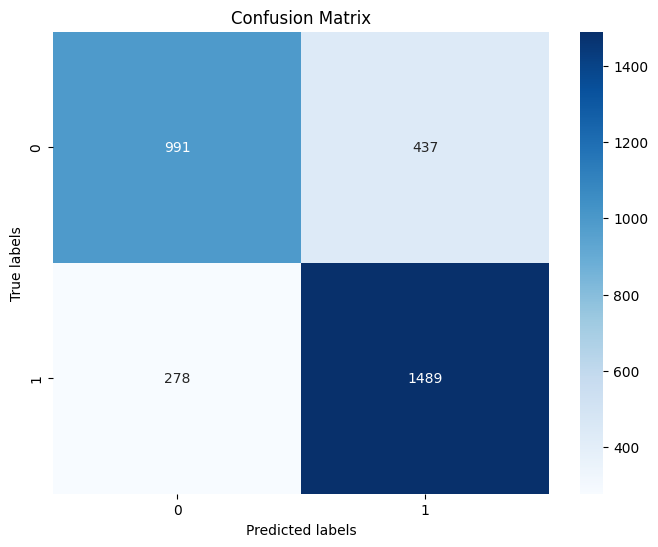

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")


Precision: 0.773104880581516
Recall: 0.842671194114318
F1 Score: 0.8063904684538316


In [ ]:
pip install xgboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

# Create an XGBoost Classifier
classifier_xgb = XGBClassifier()

# Fit the model on the training data
classifier_xgb.fit(X_train, y_train)

# Make predictions on the test data
y_pred = classifier_xgb.predict(X_test)

# Calculate the accuracy of the model
accuracy_xgb = accuracy_score(y_test, y_pred)
print(f"Accuracy of XGBoost Classifier = {accuracy_xgb*100}%")
report_rf = classification_report(y_test, y_pred)
print("Classification Report for xgb:")
print(report_rf)

Accuracy of XGBoost Classifier = 97.21439749608763%
Classification Report for xgb:
              precision    recall  f1-score   support

           0       0.98      0.96      0.97      1428
           1       0.97      0.98      0.98      1767

    accuracy                           0.97      3195
   macro avg       0.97      0.97      0.97      3195
weighted avg       0.97      0.97      0.97      3195



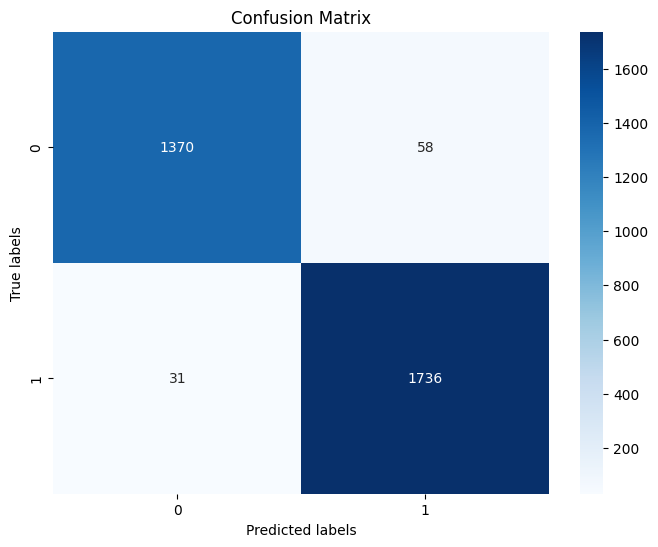

In [ ]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Precision: 0.967670011148272
Recall: 0.9824561403508771
F1 Score: 0.9750070204998595


The word2vec model has a very different outcome. First, it was not fitted to positive and negative words the same way the count and tfidf words were fitted. so there was a stark difference in the number of positive and negative sentiments. Yet, using it still had a high accuracy score, suggesting that sentiment as a feature was not givn very high importance.